### Imports

In [1]:
import pickle

import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt
%matplotlib inline

import gym
import os
print(os.environ['LD_LIBRARY_PATH'])

import load_policy
import tf_util

:/home/smdsbz/.mujoco/mjpro150/bin


In [2]:
import mujoco_py

Load expert policy.

In [3]:
policy_fn = load_policy.load_policy('./experts/Hopper-v2.pkl')

obs (1, 11) (1, 11)


In [4]:
with open('./expert_policy_Hopper-v2.pkl', 'rb') as pkl:
    data_train = pickle.load(pkl)

Check for input / output dimension.

In [5]:
with tf.Session():
    tf_util.initialize()
    env = gym.make('Hopper-v2')

    observe = env.reset()
    print(observe, 'of shape', observe.shape, observe.dtype)
    action = policy_fn(observe[None, :])
    print(action, 'of shape', action.shape, action.dtype)

Instructions for updating:
Please use tf.global_variables instead.
Instructions for updating:
Use `tf.variables_initializer` instead.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
[ 1.24817663e+00 -1.12645399e-03 -2.13389124e-03  1.68241317e-03
  2.64174695e-03 -1.85969158e-03  4.68363061e-03  1.67243508e-03
 -3.62390796e-03  4.41595712e-03 -1.45763637e-03] of shape (11,) float64
[[0.00341392 2.1313772  1.8744878 ]] of shape (1, 3) float32


### My Code

Define network.

In [6]:
observ = tf.placeholder(shape=(None, 11), dtype=tf.float64, name='observ')

with tf.name_scope('fc1'):
    hidden1 = tf.contrib.layers.fully_connected(observ,
        num_outputs=128, activation_fn=tf.nn.leaky_relu)
with tf.name_scope('fc2'):
    hidden2 = tf.contrib.layers.fully_connected(hidden1,
        num_outputs=256, activation_fn=tf.nn.leaky_relu)
with tf.name_scope('fc3'):
    hidden3 = tf.contrib.layers.fully_connected(hidden2,
        num_outputs=64, activation_fn=tf.nn.leaky_relu)
with tf.name_scope('fc_out'):
    action_hat = tf.contrib.layers.fully_connected(hidden3,
        num_outputs=3, activation_fn=tf.nn.leaky_relu)

In [18]:
action_expert = tf.placeholder(shape=[None, 1, 3], dtype=tf.float64, name='action_exp')
mseloss = tf.reduce_mean(tf.squared_difference(action_hat, action_expert))
train_op = tf.train.GradientDescentOptimizer(0.05).minimize(mseloss)

In [19]:
train_loss_rec = []

with tf.Session() as sess:
    
    tf.global_variables_initializer().run()
    
    for step_cnt in range(300):
        train_loss, _ = sess.run([mseloss, train_op],
                                 feed_dict={
                                    observ: data_train['observations'],
                                    action_expert: data_train['actions']
                                 })
        train_loss_rec.append(train_loss)
        
        if step_cnt % 10 == 0:
            print('step {}, training loss {}'.format(step_cnt + 1, train_loss))

step 1, training loss 2.5063124187839043
step 11, training loss 2.1779419358645087
step 21, training loss 2.172199034996289
step 31, training loss 2.170474041664966
step 41, training loss 2.169541519518278
step 51, training loss 2.1688974981194065
step 61, training loss 2.1684029018701074
step 71, training loss 2.1679980044450216
step 81, training loss 2.167653962956979
step 91, training loss 2.1673680169485046
step 101, training loss 2.1671282508132466
step 111, training loss 2.166922371995704
step 121, training loss 2.1667430311191334
step 131, training loss 2.1665865445810657
step 141, training loss 2.1664498321267605
step 151, training loss 2.1663288774254346
step 161, training loss 2.166221417154167
step 171, training loss 2.1661266850545307
step 181, training loss 2.1660425714777793
step 191, training loss 2.1659674983696418
step 201, training loss 2.1659006928300735
step 211, training loss 2.1658400838115845
step 221, training loss 2.1657845777876643
step 231, training loss 2.16

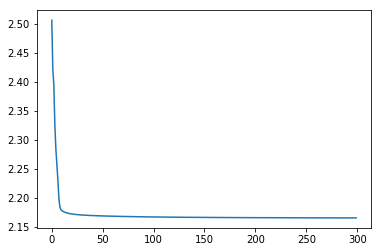

In [21]:
plt.plot(train_loss_rec)
plt.show()